In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn import preprocessing
import pydot

from graphviz import Source


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

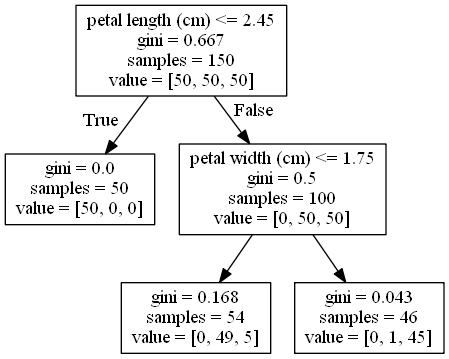

In [3]:
graph = Source(sklearn.tree.export_graphviz(tree_clf, out_file=None, feature_names=iris.feature_names[2:]))
png_bytes = graph.pipe(format='png')
with open('pics/dtree_pipe.png', 'wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [4]:
import sys
print(sys.version_info)
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO

golf = StringIO("""Outlook,Temperature,Humidity,Wind,Play
Sunny,85,85,false,no
Sunny,80,90,true,no
Overcast,83,86,false,yes
Rainy,70,96,false,yes
Rainy,68,80,false,yes
Rainy,65,70,true,no
Overcast,64,65,true,yes
Sunny,72,95,false,no
Sunny,69,70,false,yes
Rainy,75,80,false,yes
Sunny,75,70,true,yes
Overcast,72,90,true,yes
Overcast,81,75,false,yes
Rainy,71,91,true,no
""")

df = pd.read_csv(golf, sep=',')

sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [5]:
df

,Outlook,Temperature,Humidity,Wind,Play
0,Sunny,85,85,False,no
1,Sunny,80,90,True,no
2,Overcast,83,86,False,yes
3,Rainy,70,96,False,yes
4,Rainy,68,80,False,yes
5,Rainy,65,70,True,no
6,Overcast,64,65,True,yes
7,Sunny,72,95,False,no
8,Sunny,69,70,False,yes
9,Rainy,75,80,False,yes


In [6]:
X = df[['Outlook', 'Temperature', 'Humidity', 'Wind']]
y = df[['Play']]
tree_clf = DecisionTreeClassifier(max_depth=2)

In [8]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
X = np.c_[
    df[['Outlook', 'Wind']].apply(lambda x: d[x.name].fit_transform(x)).values,
    df[['Temperature', 'Humidity']].values
]
y = df[['Play']].values
print(X)
print(y)

[[ 2  0 85 85]
 [ 2  1 80 90]
 [ 0  0 83 86]
 [ 1  0 70 96]
 [ 1  0 68 80]
 [ 1  1 65 70]
 [ 0  1 64 65]
 [ 2  0 72 95]
 [ 2  0 69 70]
 [ 1  0 75 80]
 [ 2  1 75 70]
 [ 0  1 72 90]
 [ 0  0 81 75]
 [ 1  1 71 91]]
[['no']
 ['no']
 ['yes']
 ['yes']
 ['yes']
 ['no']
 ['yes']
 ['no']
 ['yes']
 ['yes']
 ['yes']
 ['yes']
 ['yes']
 ['no']]


In [9]:
o = d['Outlook']

In [10]:
o.classes_

array(['Overcast', 'Rainy', 'Sunny'], dtype=object)

In [12]:
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=3)

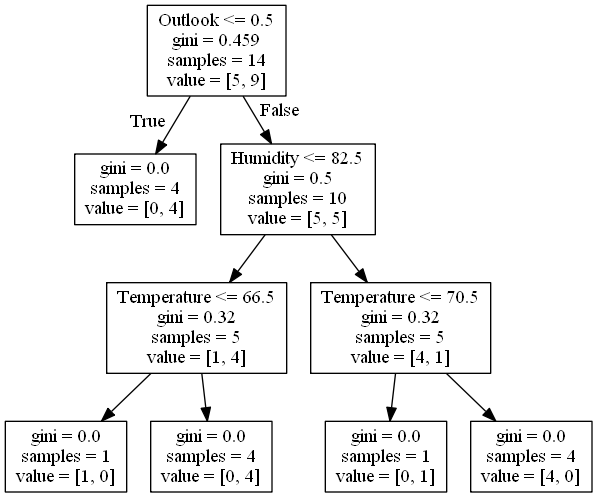

In [14]:
graph = Source(sklearn.tree.export_graphviz(tree_clf, out_file=None, feature_names=['Outlook', 'Wind', 'Temperature', 'Humidity']))
png_bytes = graph.pipe(format='png')
with open('pics/dtree_pipe.png', 'wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

# Псевдокод алгоритма

``` python
function decision_tree(X_N):
    if X_N satisfies leaf criterion:
        L = create_leaf(X_N)
        assign_class(L)
    else:
        L = create_node(X_N)
        X_1, ..., X_S = split(L)
        for i in 1..S:
            C = decidion_tree(X_i)
            add_child(L, C)
    return L
```

# CART - Classification and Regression Trees

1. Как происходит разделение?
2. На сколько детей разделять каждый узел?
3. Какой критерий листа выбрать?
4. Как выбрать класс каждого листа?
5. Что делать если часть значений отсутствует?

# Как делать разбиение?

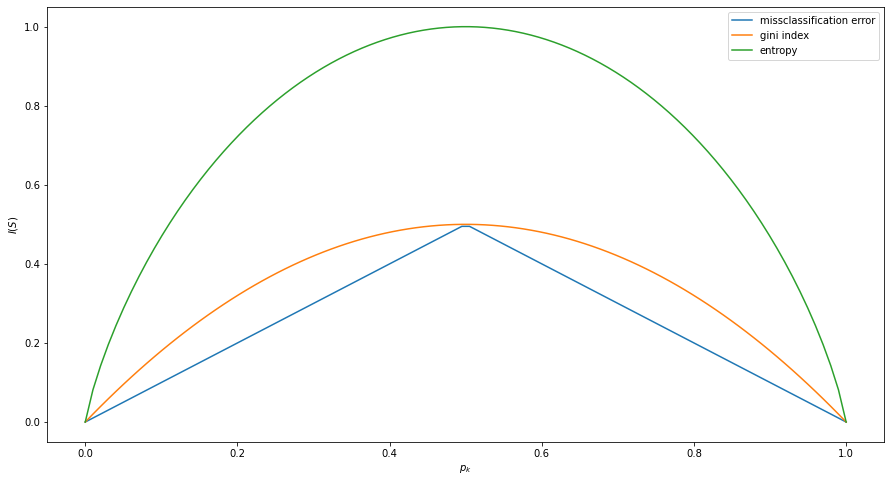

In [15]:
def plot_impurities():
    threshold = 0.000001
    p = np.linspace(0, 1, 100)
    p = np.c_[p, 1 - p]
    
    missclass = 1 - p.max(axis=1)
    plt.plot(p[:,0], missclass, label='missclassification error')
    
    gini = 1 - (p ** 2).sum(axis=1)
    plt.plot(p[:, 0], gini, label = 'gini index')
    
    entropy = - np.nansum((p * np.log2(np.clip(p, threshold, 1 - threshold))), axis=1)
    plt.plot(p[:, 0], entropy, label = 'entropy')
    
    plt.xlabel('$p_k$')
    plt.ylabel('$I(S)$')
    plt.legend()

plot_impurities()
    

In [16]:
n = 10 

In [18]:
ME_1_left = 1 - 5./5 
ME_1_left  # 0

0.0

In [19]:
ME_1_right = 1 - 3/5.
ME_1_right  # 4/10

0.4

In [21]:
ME_all = 1 - 7. / 10
ME_all

0.30000000000000004

In [22]:
# 1
ME_all - ((5 / n) * ME_1_left + (5 / n) * ME_1_right)

0.10000000000000003

In [23]:
(5 / n) * ME_1_left, (5 / n) * ME_1_right

(0.0, 0.2)

In [25]:
df[['Temperature', 'Play']]

,Temperature,Play
0,85,no
1,80,no
2,83,yes
3,70,yes
4,68,yes
5,65,no
6,64,yes
7,72,no
8,69,yes
9,75,yes


In [26]:
df[['Temperature', 'Play']].sort_values('Temperature')

,Temperature,Play
6,64,yes
5,65,no
4,68,yes
8,69,yes
3,70,yes
13,71,no
7,72,no
11,72,yes
9,75,yes
10,75,yes


In [37]:
 DecisionTreeClassifier(
     class_weight=None, criterion='gini', max_depth=3,
     max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
     min_samples_leaf=1, min_samples_split=2,
     min_weight_fraction_leaf=0.0, random_state=None,
     splitter='best')

DecisionTreeClassifier(max_depth=3)

# Регрессия

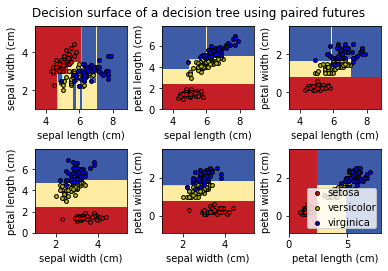

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = 'ryb'
plot_step = 0.02

# load data
iris = load_iris()

for pairidx , pair in enumerate([[0, 1], [0, 2], [0, 3],
                                 [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding seatures
    X = iris.data[:, pair]
    y = iris.target
    
    # Train
    clf = DecisionTreeClassifier().fit(X, y)
    
    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    
    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    
    # Plot the training points
    
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                   cmap=plt.cm.RdYlBu, edgecolor='black', s=15)



plt.suptitle('Decision surface of a decision tree using paired futures')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis('tight')
plt.show()
        

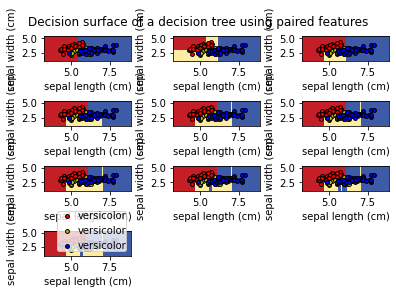

In [17]:
pair = [0, 1]
# we only take the two corresponding features
X = iris.data[:, pair]
y = iris.target

for d in range(10):
    # train
    clf = DecisionTreeClassifier(max_depth=d+1).fit(X, y)
    
    # plot the decision boundary
    plt.subplot(4, 3, d + 1)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    
    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    
    # Plot the training points
    
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[1],
                   cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle('Decision surface of a decision tree using paired features')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis('tight')
plt.show()

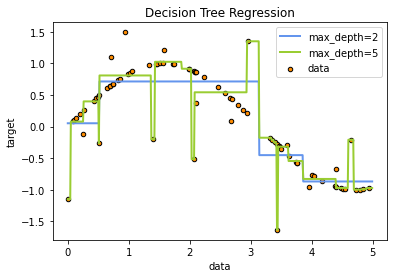

In [21]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create random dataset

rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()

y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regressial model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor='black',
            c='darkorange', label='data')
plt.plot(X_test, y_1, color='cornflowerblue', label='max_depth=2', linewidth=2)
plt.plot(X_test, y_2, color='yellowgreen', label='max_depth=5', linewidth=2)
plt.xlabel('data')
plt.ylabel('target')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

